In [27]:
import requests, json, csv, re
import pandas as pd
import numpy as np


AKUurl = 'https://api.statbank.dk/v1/data/AKU125/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&S%C3%86SON=11&S%C3%86SON=10&BESKSTATUS=LPCT&TID=*'
AKUcsv = pd.read_csv(AKUurl, sep = ";")

unemp_url = 'https://api.statbank.dk/v1/data/AUS07/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&YD=TOT&YD=NET&TID=*&SAESONFAK=9&SAESONFAK=22'
raw_unemp = pd.read_csv(unemp_url, sep = ";")
AKUcsv.head(5)

,SÆSON,BESKSTATUS,TID,INDHOLD
0,Non-seasonally adjusted,ILO-unemployment rate,2018M06,5.0
1,Non-seasonally adjusted,ILO-unemployment rate,2018M05,4.9
2,Non-seasonally adjusted,ILO-unemployment rate,2018M04,5.1
3,Non-seasonally adjusted,ILO-unemployment rate,2018M03,5.1
4,Non-seasonally adjusted,ILO-unemployment rate,2018M02,5.2


In [28]:
AKUcsv['season_adj'] = np.where(AKUcsv['SÆSON'] == 'Non-seasonally adjusted', 0, 1)
AKUcsv.columns = ['todrop', 'type', 'time', 'rate', 'season_adj']
AKUcsv['type'] = AKUcsv['type'].str.replace(r'rate', r'')
AKU = AKUcsv.drop('todrop', axis=1)

raw_unemp['season_adj'] = np.where(raw_unemp['SAESONFAK'] == 'Seasonally adjusted figures in percent of the labour force', 1, 0)
raw_unemp.columns = ['type', 'time', 'SAESONFAK', 'rate', 'season_adj']
unemp = raw_unemp.drop('SAESONFAK', axis=1)

In [29]:
# merge data to long format.
# Now we have 6 unemp_rates per month. 3 types, all both w/ and w/o seasonal correction. 
all_long = pd.concat([AKU, unemp], ignore_index=True)

# shortening of type names
all_long['type'] = all_long['type'].str.replace(r'unemployment', r'unempl')
all_long.head(3)

,type,time,rate,season_adj
0,ILO-unempl,2018M06,5.0,0
1,ILO-unempl,2018M05,4.9,0
2,ILO-unempl,2018M04,5.1,0


In [30]:
# Nice view for comparison, not workable going forward
all_wide_nice = all_long.pivot_table(index = 'time', columns= ['type','season_adj'], values= 'rate')
all_wide_nice.head(3)

type       Gross unempl      ILO-unempl       Net unempl     
season_adj            0    1           0    1          0    1
time                                                         
2007M01             4.7  4.3         4.2  4.1        3.7  3.2
2007M02             4.6  4.1         4.3  3.9        3.6  3.2
2007M03             4.3  3.9         3.9  3.7        3.3  3.0

In [31]:
# creating timestamp 
# NB: Timestamping converts YYYYMM to YYYY-MM-01
import datetime
all_long['time'] = all_long['time'].str.replace(r'\D', r' ')

all_long['time'] = pd.to_datetime(all_long['time'], format = "%Y %m" )

print(all_long.tail(3))
all_long.dtypes

           type       time  rate  season_adj
825  Net unempl 2007-02-01   3.6           0
826  Net unempl 2007-01-01   3.2           1
827  Net unempl 2007-01-01   3.7           0


type                  object
time          datetime64[ns]
rate                 float64
season_adj             int32
dtype: object

In [32]:
all_long['measure'] = all_long['season_adj'].map(str) + str(" ") + all_long['type'].map(str)
all_long = all_long.drop(['type', 'season_adj'], axis=1)
all_wide = all_long.pivot('time', 'measure', 'rate')
all_wide.head(3)


measure,0 Gross unempl,0 ILO-unempl,0 Net unempl,1 Gross unempl,1 ILO-unempl,1 Net unempl
time,,,,,,
2007-01-01,4.7,4.2,3.7,4.3,4.1,3.2
2007-02-01,4.6,4.3,3.6,4.1,3.9,3.2
2007-03-01,4.3,3.9,3.3,3.9,3.7,3.0


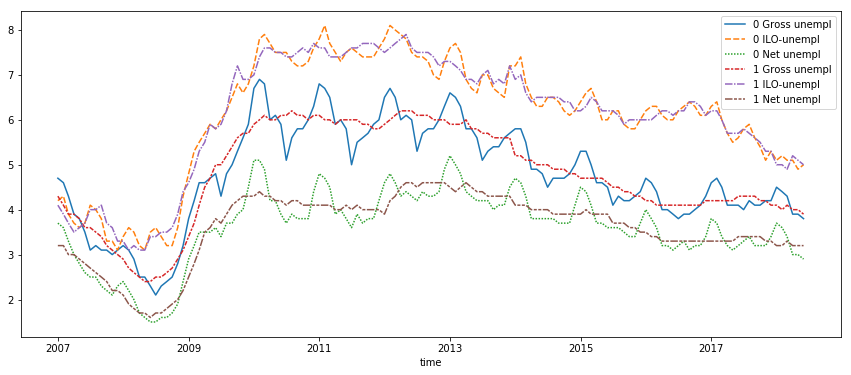

In [33]:
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(figsize = (14.7, 6))
sns.lineplot(ax=ax, data=all_wide)



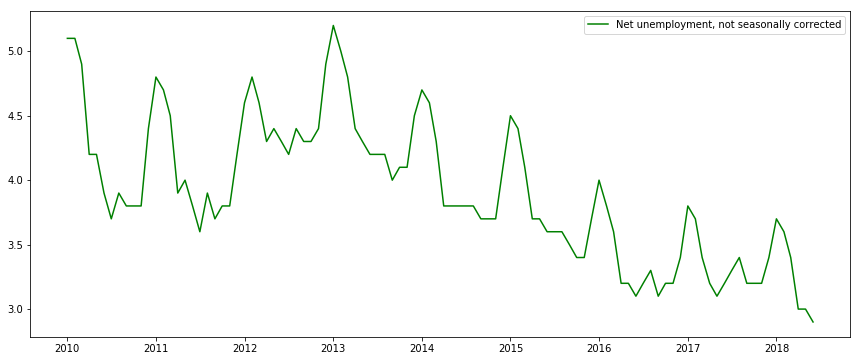

In [36]:
fig, ax = pyplot.subplots(figsize = (14.7, 6))
sns.lineplot(ax=ax, data=all_wide['0 Net unempl']['2010-01-01':], color="green", label = "Net unemployment, not seasonally corrected")

In [16]:
from pandas.plotting import lag_plot
series = nunemp['rate']
lag_plot(series, lag =1)

pyplot.show()

NameError: name 'nunemp' is not defined

In [ ]:
import datetime, requests, json, datetime
url = 'https://trends.google.dk/trends/api/widgetdata/multiline?hl=da&tz=-120&req=%7B%22time%22:%222007-01-01+2018-08-28%22,%22resolution%22:%22MONTH%22,%22locale%22:%22da%22,%22comparisonItem%22:%5B%7B%22geo%22:%7B%22country%22:%22DK%22%7D,%22complexKeywordsRestriction%22:%7B%22keyword%22:%5B%7B%22type%22:%22BROAD%22,%22value%22:%22job%22%7D%5D%7D%7D%5D,%22requestOptions%22:%7B%22property%22:%22%22,%22backend%22:%22IZG%22,%22category%22:0%7D%7D&token=APP6_UEAAAAAW4ZTdqk6LyiG1wwdFTWY_HTaBeZrubIr&tz=-120'

response = requests.get(url)
print(response.ok)
print('-----')
dict = json.loads(response.text.split(")]}\',\n")[1])
#print(dict)

dict_length = len(dict['default']['timelineData'])
timelinedata_list = [] 

for i in range(0,dict_length):
    # Extracting value (keyword: 'time')
    time = dict['default']['timelineData'][i]['time']
    
    year = datetime.utcfromtimestamp(int(time)).strftime('%Y')
    month = datetime.utcfromtimestamp(int(time)).strftime('%m')

    # Extracting value (keyword: 'value'). Pulling out first element, since list with one element.
    value = dict['default']['timelineData'][i]['value'][0]
        
    help_list =[]
    help_list.append(year)
    help_list.append(month)
    help_list.append(value)
    timelinedata_list.append(help_list)
    
#print(timelinedata_list)

df = pd.DataFrame(timelinedata_list)
df.columns = ['Year', 'Month' , 'Average_SVI']
#print(df)

df2 = df.groupby(['Year', 'Month'], as_index=False).mean()

In [ ]:
# n_lags = 1 & 2

# Read net unemployment data from csv
nunemp = all_wide.iloc[:,0]
nunemp = nunemp.to_frame('rate')
nunemp['lag1'] = nunemp['rate'].shift(1)
nunemp['lag2'] = nunemp['rate'].shift(2)
nunemp.head(5)

In [ ]:
unemp_rates['Year'] =  [x[0:4] for x in unemp_rates['Date']]
unemp_rates['Month'] =  [x[5:] for x in unemp_rates['Date']]
# Create varaible lagged unemplyment rate
df2['Bruttoledige_lag1'] = unemp_rates['Bruttoledige'].shift(n_lags)

# Create variable lagged average SVI
df3 = df2.copy()
df3['Average_SVI_lag1'] = df3['Average_SVI'].shift(n_lags)